# MLP-12 For Digit Recognition on MNIST

**Architecture: 784-FC:12-10**

Here, 
- FC: Fully connected layer with ReLU activation

**Naming Conventions**
- Small letter variables are local to a section
- Capitalized variables are used across sections
- Functions are always assumed to be used across sections

# Environment Setup

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1  Device: cuda


# Loading Dataset

Dataset will be downloaded using PyTorch into a local directory.

In [2]:
data_path = "./dataset"

Train_dataset = datasets.MNIST(data_path, 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

Test_dataset = datasets.MNIST(data_path, 
                                    train=False, 
                                    transform=transforms.ToTensor())

# Explore Dataset to Understand

Note: 
- MNIST data items are a tuple of image and a label. 
- The image is a tensor of dimension (1, 28, 28). The first axis if probably for the image channel. As it is a grayscale image, there is only one channel.
- The label is a number corresponding to the image.

In [3]:
# Check out an item
item = Train_dataset[0]
print('item:', type(item), '  len:', len(item))
print('item[0]:', type(item[0]), '  item[1]:', type(item[1]))
print('item[0]:', item[0].size())

img = item[0].flatten()
print('')
print('min:', torch.min(img))
print('max:', torch.max(img))
print('avg:', torch.mean(img))

item: <class 'tuple'>   len: 2
item[0]: <class 'torch.Tensor'>   item[1]: <class 'int'>
item[0]: torch.Size([1, 28, 28])

min: tensor(0.)
max: tensor(1.)
avg: tensor(0.1377)


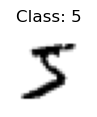

In [4]:
# Show an example data item
def showItem(item, newfig=True):
    if newfig: plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(item[0].numpy().reshape(28,28), cmap="gray_r")
    plt.title(f'Class: {item[1]}')

    
showItem(item, newfig=True)

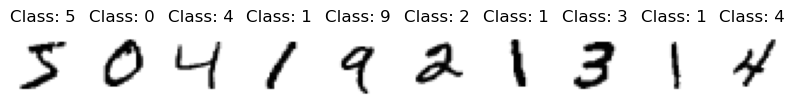

In [5]:
# Show a few more items
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    item = Train_dataset[i]
    plt.subplot(1,10,i+1)
    showItem(item, newfig=False)

# Trim Down Dataset

If needed, trim down the dataset here for faster experimentation

In [6]:
print('Train:', len(Train_dataset))
print('Test :', len(Test_dataset))

Train: 60000
Test : 10000


# Define Features and Labels

The features for this MLP12 model are selected to be the raw image pixels. The image is flattened into a 1-D tensor to create the feature vector.

In [7]:
# Given a data item, returns the features
def extract_feature(item):
    return item[0].flatten()


# Compute the feature length
item = Train_dataset[0]
feat = extract_feature(item)
Feature_length = len(feat)

print('feat:', feat.size())
print('Feature_length:', Feature_length)

feat: torch.Size([784])
Feature_length: 784


In [8]:
# Get the labels
all_labels = set()
for item in tqdm(Train_dataset):
    all_labels.add(item[1])

Labels = sorted(list(all_labels))
print('Labels:', Labels)

  0%|          | 0/60000 [00:00<?, ?it/s]

Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Define Model

In [9]:
# Define an MLP with single hiddend layer with 12 units and ReLU activation.
class MLP12(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP12, self).__init__()
        # Save parameters
        self.input_size = input_size
        self.num_classes = num_classes
        self.debug = False    # can be used to activate debugging features
        # Define layers
        self.fc1 = nn.Linear(input_size, 12)   # 12 hidden units
        self.fc1_drop = nn.Dropout(0.2)        # drop-out for faster training, has no effect on inference
        self.fc2 = nn.Linear(12, num_classes)  # output layer

    # Expects a batch of 1-D tensor
    # Dimension of x: (batch-size, input_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))   # pass through the hidden layer
        x = self.fc1_drop(x)      
        x = self.fc2(x)           # pass through the output layer
        return x

In [10]:
# Instantiate the model and optimizer
input_size = Feature_length
num_classes = len(Labels)

model_mlp12 = MLP12(input_size, num_classes).to(device)
optimizer = torch.optim.SGD(model_mlp12.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()


# Save the model parameters
save_path = './phone-recog/model-hparam-v1.pt'
Hparam = {
    'input_size' : input_size,
    'num_classes': num_classes, 
}

# Define Dataloaders

In [12]:
# Gets a batch of data item, 
# Converts it into a batch of (feature, label) for the model
def collate_fn(batch):
    tensors, targets = [], []
    # Extract features and labels into lists
    for item in batch:
        feat = extract_feature(item)
        label = item[1]
        tensors.append(feat)
        targets.append(label)
    # Convert to tensors
    tensors = torch.stack(tensors)
    targets = torch.tensor(targets)
    return tensors, targets


# Test collate_fn
batch = [Train_dataset[i] for i in range(5)]
feat, label = collate_fn(batch)
print('feat :', feat.size())
print('label:', label)

feat : torch.Size([5, 784])
label: tensor([5, 0, 4, 1, 9])


In [13]:
Batch_size_train = 64
Batch_size_test  = 32

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    

Train_loader = torch.utils.data.DataLoader(
    dataset=Train_dataset, 
    batch_size=Batch_size_train, 
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

Test_loader = torch.utils.data.DataLoader(
    dataset=Test_dataset, 
    batch_size=Batch_size_test, 
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
# Test the dataloaders
for (X_train, y_train) in Train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

print('')
for (X_test, y_test) in Test_loader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    break
  

X_train: torch.Size([64, 784]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor

X_test: torch.Size([32, 784]) type: torch.FloatTensor
y_test: torch.Size([32]) type: torch.LongTensor


# Training and Testing Methods

In [15]:
from math import ceil

def train_model(model, epoch, log_interval, debug=False):
    model.train()
    model.debug = debug
    total_batch = ceil(len(Train_dataset)/Batch_size_train)  # for tqdm
    for batch_idx, (features, targets) in tqdm(enumerate(Train_loader), total=total_batch, desc=f'Epoch {epoch}'):
        features = features.to(device)
        targets = targets.to(device)

        # Run through model and compute loss
        outputs = model(features)
        loss = criterion(outputs, targets)    # compute batch loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{:6}/{} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(features), len(Train_loader.dataset),
                100. * batch_idx / len(Train_loader), loss.data.item()))
        # Debug
        if debug and batch_idx == 100: 
            print('DBG: Breaking prematurely')
            break

        # record loss
        train_loss.append(loss.item())
    model.debug = False

In [24]:
def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def test_model(model, epoch, debug=False):
    model.eval()
    model.debug = debug
    # Run the test dataset through the model
    loss, correct = 0, 0
    for features, targets in Test_loader:
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss += criterion(outputs, targets).data.item()
        pred = get_likely_index(outputs) # get the index of the max log-probability
        correct += number_of_correct(pred, targets)
    model.debug = False
    
    # Print statistics
    loss /= len(Test_loader)
    test_loss.append(loss)
    accuracy = (100.0 * correct) / len(Test_loader.dataset)
    test_accuracy.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss, correct, len(Test_loader.dataset), accuracy))
    

# Run Training

In [25]:
%%time

log_interval_percent = 10
log_interval = (len(Train_dataset)//Batch_size_train) * log_interval_percent // 100
n_epoch = 3
train_loss = []
test_loss = []
test_accuracy = []

#train_lstm(model_lstm, epoch, log_interval, pbar)
for epoch in tqdm(range(n_epoch), desc="Training"):
    train_model(model_mlp12, epoch, log_interval, debug=False)
    test_model(model_mlp12, epoch, debug=False)

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 0 [     0/60000 ( 0%)]	Loss: 0.423386
Train Epoch: 0 [  5952/60000 (10%)]	Loss: 0.776430
Train Epoch: 0 [ 11904/60000 (20%)]	Loss: 0.541689
Train Epoch: 0 [ 17856/60000 (30%)]	Loss: 0.430597
Train Epoch: 0 [ 23808/60000 (40%)]	Loss: 0.459428
Train Epoch: 0 [ 29760/60000 (50%)]	Loss: 0.372158
Train Epoch: 0 [ 35712/60000 (59%)]	Loss: 0.571633
Train Epoch: 0 [ 41664/60000 (69%)]	Loss: 0.400734
Train Epoch: 0 [ 47616/60000 (79%)]	Loss: 0.503336
Train Epoch: 0 [ 53568/60000 (89%)]	Loss: 0.526712
Train Epoch: 0 [ 59520/60000 (99%)]	Loss: 0.600360

Validation set: Average loss: 0.3587, Accuracy: 9012/10000 (90.12%)



Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 [     0/60000 ( 0%)]	Loss: 0.652058
Train Epoch: 1 [  5952/60000 (10%)]	Loss: 0.451524
Train Epoch: 1 [ 11904/60000 (20%)]	Loss: 0.481821
Train Epoch: 1 [ 17856/60000 (30%)]	Loss: 0.335334
Train Epoch: 1 [ 23808/60000 (40%)]	Loss: 0.614445
Train Epoch: 1 [ 29760/60000 (50%)]	Loss: 0.535701
Train Epoch: 1 [ 35712/60000 (59%)]	Loss: 0.359332
Train Epoch: 1 [ 41664/60000 (69%)]	Loss: 0.641386
Train Epoch: 1 [ 47616/60000 (79%)]	Loss: 0.724135
Train Epoch: 1 [ 53568/60000 (89%)]	Loss: 0.499224
Train Epoch: 1 [ 59520/60000 (99%)]	Loss: 0.565896

Validation set: Average loss: 0.3390, Accuracy: 9054/10000 (90.54%)



Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 [     0/60000 ( 0%)]	Loss: 0.501750
Train Epoch: 2 [  5952/60000 (10%)]	Loss: 0.740448
Train Epoch: 2 [ 11904/60000 (20%)]	Loss: 0.422388
Train Epoch: 2 [ 17856/60000 (30%)]	Loss: 0.513928
Train Epoch: 2 [ 23808/60000 (40%)]	Loss: 0.401850
Train Epoch: 2 [ 29760/60000 (50%)]	Loss: 0.519003
Train Epoch: 2 [ 35712/60000 (59%)]	Loss: 0.451006
Train Epoch: 2 [ 41664/60000 (69%)]	Loss: 0.597384
Train Epoch: 2 [ 47616/60000 (79%)]	Loss: 0.592695
Train Epoch: 2 [ 53568/60000 (89%)]	Loss: 0.652482
Train Epoch: 2 [ 59520/60000 (99%)]	Loss: 0.458243

Validation set: Average loss: 0.3263, Accuracy: 9095/10000 (90.95%)

CPU times: user 27.2 s, sys: 636 ms, total: 27.8 s
Wall time: 20.3 s


Text(0.5, 1.0, 'Test Accuracy')

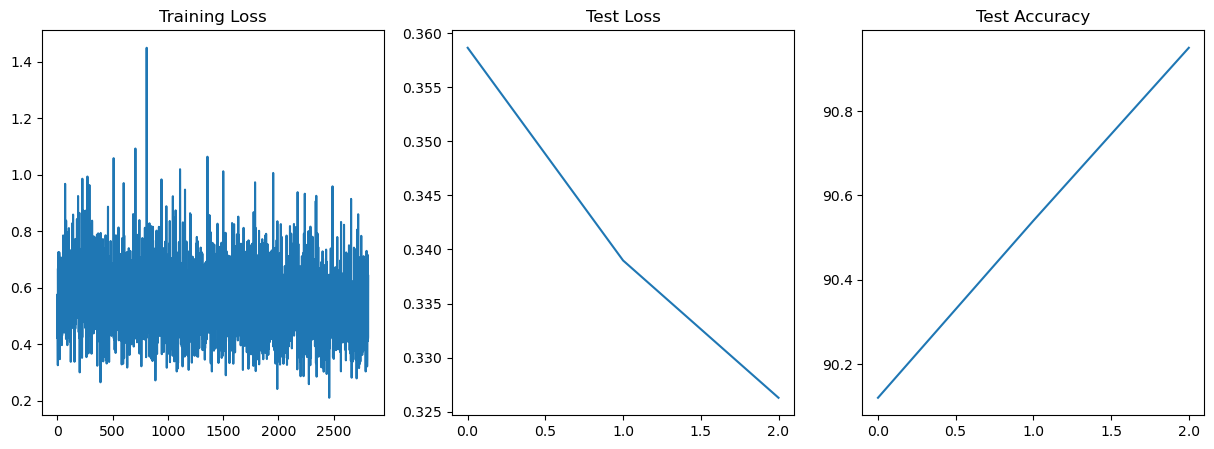

In [26]:
# Let's plot the training loss versus the number of iteration.
fig_height = 5
plt.figure(figsize=(3*fig_height, fig_height))

plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.title("Training Loss")

plt.subplot(1, 3, 2)
plt.plot(test_loss)
plt.title("Test Loss")

plt.subplot(1, 3, 3)
plt.plot(test_accuracy)
plt.title("Test Accuracy")

# Test the Trained Model

Expected: 6. Predicted: 6.


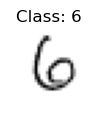

In [27]:
# Return the prediction
def predict(item):  # item: an item in the dataset
    model_mlp12.eval()
    # Extract features
    batch = [item]  # make a batch with single example
    tensor, target = collate_fn(batch)
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    target = target.to(device)
    output = model_mlp12(tensor)
    pred = get_likely_index(output)[0]   # indexing to get the prediction from batch
    return pred


# Run a prediction
select_index = 100
item = Test_dataset[select_index]
pred = predict(item)
print(f"Expected: {item[1]}. Predicted: {pred}.")
showItem(item)

# Save Model and Test Dataset

In [28]:
# Saving the Model with hyper-parameters
save_path = './saved/trained_mlp12.pt'
model_dict = {
    'Hparam'    : Hparam,   # Hparam was defined while instantiating the model
    'state_dict': model_mlp12.state_dict()
}
torch.save(model_dict, save_path)
!ls -ltrh ./saved

total 68M
-rw-rw-r-- 1 makabir makabir 68M Jun 16 20:19 test_dataset.pt
-rw-rw-r-- 1 makabir makabir 39K Jun 16 20:37 trained_mlp12.pt


## Saving Test Dataset and Prediction

Saves the test dataset and the prediction by the trained model as the following dictionary:  
- accuracy: percent accuracy as float
- correct_count: no. of correct prediction as integer
- label_dict: {label: index}
- dataset_schema: structure of dataset items
- dataset: list of items
    - item: (label, label_index, predicted_index, feature_length, feature_vector)


In [32]:
correct_count = 0
dataset = []
for data in tqdm(Test_dataset):
    pred = predict(data)
    feature, target = collate_fn([data])   # as batch with single item
    feature, target = feature[0], target[0]
    item = [data[1], target.item(), pred.item(), len(feature), feature.tolist()]
    if pred==data[1]: correct_count += 1
    dataset.append(item)
    
print('dataset:', len(dataset), '  Test_dataset:', len(Test_dataset))
print('correct_count:', correct_count)

  0%|          | 0/10000 [00:00<?, ?it/s]

dataset: 10000   Test_dataset: 10000
correct_count: 9095


In [33]:
# Print an item in the dataset
item = dataset[0][:-1]  # Everything except feature_vector
feat_vec = dataset[0][-1]

print('item:', item)  
print('feat_vec:', type(feat_vec), len(feat_vec))

item: [7, 7, 7, 784]
feat_vec: <class 'list'> 784


In [34]:
accuracy = (100.0 * correct_count) / len(Test_dataset)
print(f'accuracy: {accuracy:.2f}%')

label_dict = {label:label for label in Labels}
print('label_dict:', label_dict)

accuracy: 90.95%
label_dict: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [35]:
schema = "(label, label_index, predicted_index, feature_length, feature_vector)"
export_test = {
    'accuracy' : accuracy,
    'correct_count': correct_count,
    'label_dict': label_dict,
    'dataset_schema': schema,
    'dataset': dataset
}

# Test exported dictionary
keys = list(export_test.keys())
keys.remove('dataset')
for k in keys:
    print(k+':', export_test[k])

item = dataset[0][:-1]  # Everything except feature_vector
feat_vec = dataset[0][-1]
print('item:', item)  
print('feat_vec:', type(feat_vec), len(feat_vec))

accuracy: 90.95
correct_count: 9095
label_dict: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
dataset_schema: (label, label_index, predicted_index, feature_length, feature_vector)
item: [7, 7, 7, 784]
feat_vec: <class 'list'> 784


In [36]:
# Save the dataset dictionary as PyTorch object
save_path = './saved/test_dataset.pt'
torch.save(export_test, save_path)
!ls -ltrh ./saved

total 68M
-rw-rw-r-- 1 makabir makabir 39K Jun 16 20:37 trained_mlp12.pt
-rw-rw-r-- 1 makabir makabir 68M Jun 16 20:38 test_dataset.pt


# Test prediction from Exported Dataset item

## Dataset related utilities

In [37]:
# Prints a dataset item
def print_dataitem(item):
    mstr = f"label: {item[0]}, label_index: {item[1]}, predicted_index: {item[2]}, feature_length: {item[3]},"
    mstr2 = f"feature_vector size: {len(item[4])}"
    print(mstr, mstr2)
    
    
# Given an item form the test_dataset, returns an example for predict() function
def make_example(data_item):
    feature = torch.tensor(data_item[4])
    return feature


# test prediction from dataset item
def predict_dataset(example):  # example: feature_vector
    model_mlp12.eval()
    # Use the model to predict the label of the waveform
    feature = example.to(device)
    output = model_mlp12(feature.unsqueeze(0))
    #print(output)
    pred = get_likely_index(output)[0]   # indexing to get the prediction from batch
    return pred.item()

## Load and Test the Saved Dataset

In [38]:
# Load dataset and predict using an item from it
ds_path = './saved/test_dataset.pt'
loaded_ds = torch.load(ds_path)
item = loaded_ds['dataset'][0]
example = make_example(item)
pred = predict_dataset(example)
print('pred:',pred)
print_dataitem(item)

pred: 7
label: 7, label_index: 7, predicted_index: 7, feature_length: 784, feature_vector size: 784


# Concluding Remarks

Now you can continue to the next notebook to implement the model with basic matrix-vector operations without using any PyTorch ML/DL related features. Be careful with the **dataset schema**.